<a href="https://colab.research.google.com/github/SayanDas07/KWS-using-FewShotLearning/blob/main/FinalBaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Jun 12 14:53:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p data_10_wav/data

In [ ]:
!wget -O speech_commands_v0.02.tar.gz http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz

--2025-06-12 14:53:58--  http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.68.207, 74.125.24.207, 142.250.4.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.68.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2428923189 (2.3G) [application/gzip]
Saving to: ‘speech_commands_v0.02.tar.gz’

speech_commands_v0. 100%[===================>]   2.26G  21.2MB/s    in 1m 48s  

2025-06-12 14:55:46 (21.4 MB/s) - ‘speech_commands_v0.02.tar.gz’ saved [2428923189/2428923189]



In [ ]:
!tar -xzf speech_commands_v0.02.tar.gz -C data_10_wav/data

In [ ]:
DATASET_PATH = "data_10_wav/data/"
save_path = "/content/drive/MyDrive/NITDGP/Base Model Variations/UnknownIs3000"

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import librosa

In [ ]:
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(save_path, exist_ok=True)

In [ ]:
SAMPLES_TO_CONSIDER = 16000
frame_length = int(SAMPLES_TO_CONSIDER * (32 / 1000))
hop_length = int(SAMPLES_TO_CONSIDER * (16 / 1000))
MAX_UNKNOWN = 3000
UNKNOWN_PER_FOLDER_LIMIT = 150
unknown_count = 0
EXAMPLES_PER_FOLDER = 2

In [ ]:
labels = []
log_mel_spectrograms = []

In [ ]:
print(labels)

[]


In [ ]:
keyword_list = ['off', 'left', 'down', 'up', 'go', 'on', 'stop', 'unknown', 'right', 'yes']
keyword_index_dict = {k: i for i, k in enumerate(keyword_list)}
print("Keyword Index Mapping:", keyword_index_dict)

Keyword Index Mapping: {'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5, 'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9}


In [ ]:
from collections import defaultdict
class_sample_counts = defaultdict(int)
unknown_folder_counts = defaultdict(int)
unknown_folder_examples = defaultdict(list)

In [ ]:
def hamming_window(length):
    return 0.54 - 0.46 * np.cos(2 * np.pi * np.arange(length) / (length - 1))

In [ ]:
for dirpath, dirnames, filenames in os.walk(DATASET_PATH):
    if dirpath != DATASET_PATH:
        label = os.path.basename(dirpath)
        if label == '_background_noise_':
          continue
        final_label = label if label in keyword_list else 'unknown'
        print(f"\nProcessing: '{label}' as '{final_label}'")

        per_class_count = 0
        filenames.sort()

        for f in filenames:
            if final_label == 'unknown':
                if unknown_count >= MAX_UNKNOWN:
                    break
                if per_class_count >= UNKNOWN_PER_FOLDER_LIMIT:
                    break

            file_path = os.path.join(dirpath, f)
            try:
                signal, sample_rate = librosa.load(file_path, sr=16000)
            except Exception as e:
                print(f"Error loading file {file_path}: {e}")
                continue

            if len(signal) >= SAMPLES_TO_CONSIDER:
                signal = signal[:SAMPLES_TO_CONSIDER]
            else:
                signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

            signal = signal.astype(np.float32)
            windowed_signal = signal * hamming_window(SAMPLES_TO_CONSIDER)

            mel_spec = librosa.feature.melspectrogram(
                y=windowed_signal,
                sr=16000,
                n_mels=40,
                n_fft=frame_length,
                win_length=frame_length,
                hop_length=hop_length,
                center=False
            )

            log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel_spectrograms.append(log_mel_spec.T)
            labels.append(keyword_index_dict[final_label])

            per_class_count += 1
            class_sample_counts[final_label] += 1

            if final_label == 'unknown':
                unknown_count += 1
                folder_name = os.path.basename(dirpath)
                unknown_folder_counts[folder_name] += 1
                if len(unknown_folder_examples[folder_name]) < EXAMPLES_PER_FOLDER:
                    unknown_folder_examples[folder_name].append(log_mel_spec)

            if per_class_count >= 3000 and final_label != 'unknown':
                print(f"{final_label} : {keyword_index_dict[final_label]} = {per_class_count}")
                print(log_mel_spec.T.shape)
                break

print(f"\n✅ Final 'unknown' sample count: {unknown_count}")
print("\n📦 Sample count per class:")
for k, v in class_sample_counts.items():
    print(f"'{k}': {v}")


Processing: 'follow' as 'unknown'

Processing: 'backward' as 'unknown'

Processing: 'tree' as 'unknown'

Processing: 'happy' as 'unknown'

Processing: 'wow' as 'unknown'

Processing: 'bed' as 'unknown'

Processing: 'nine' as 'unknown'

Processing: 'five' as 'unknown'

Processing: 'stop' as 'stop'
stop : 6 = 3000
(61, 40)

Processing: 'marvin' as 'unknown'

Processing: 'go' as 'go'
go : 4 = 3000
(61, 40)

Processing: 'no' as 'unknown'

Processing: 'bird' as 'unknown'

Processing: 'up' as 'up'
up : 3 = 3000
(61, 40)

Processing: 'four' as 'unknown'

Processing: 'eight' as 'unknown'

Processing: 'seven' as 'unknown'

Processing: 'forward' as 'unknown'

Processing: 'sheila' as 'unknown'

Processing: 'zero' as 'unknown'

Processing: 'one' as 'unknown'

Processing: 'off' as 'off'
off : 0 = 3000
(61, 40)

Processing: 'learn' as 'unknown'

Processing: 'on' as 'on'
on : 5 = 3000
(61, 40)

Processing: 'yes' as 'yes'
yes : 9 = 3000
(61, 40)

Processing: 'house' as 'unknown'

Processing: 'right' 

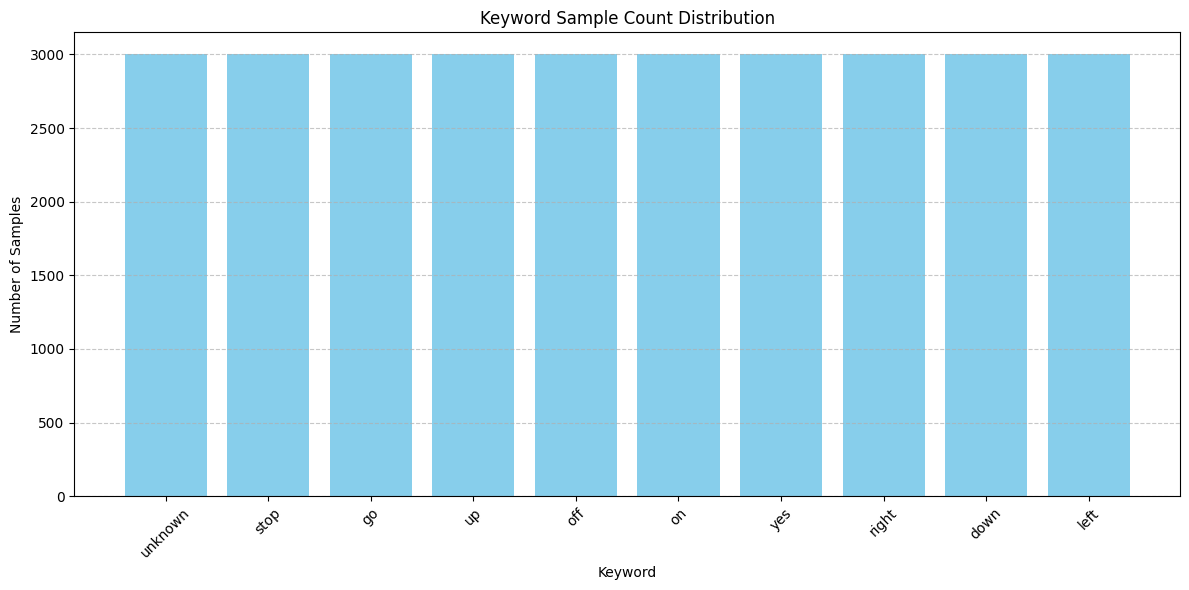

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(class_sample_counts.keys(), class_sample_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Keyword Sample Count Distribution")
plt.xlabel("Keyword")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

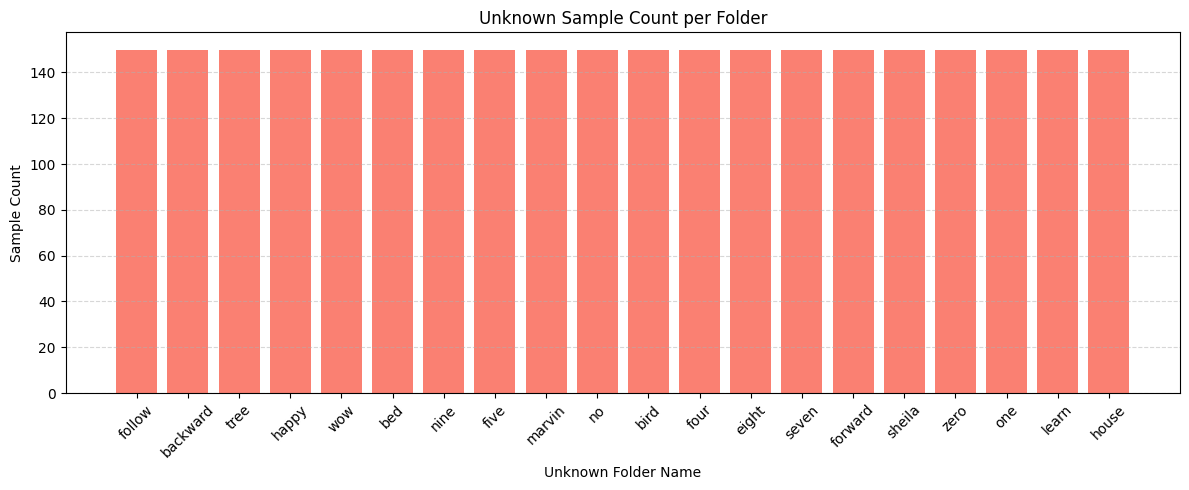

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(unknown_folder_counts.keys(), unknown_folder_counts.values(), color='salmon')
plt.title("Unknown Sample Count per Folder")
plt.xlabel("Unknown Folder Name")
plt.ylabel("Sample Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import librosa.display
def plot_mel_spectrogram(spec, label_idx):
    plt.figure(figsize=(6, 4))
    plt.imshow(spec.T, aspect='auto', origin='lower')
    plt.title(f"Label: {keyword_list[label_idx]}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


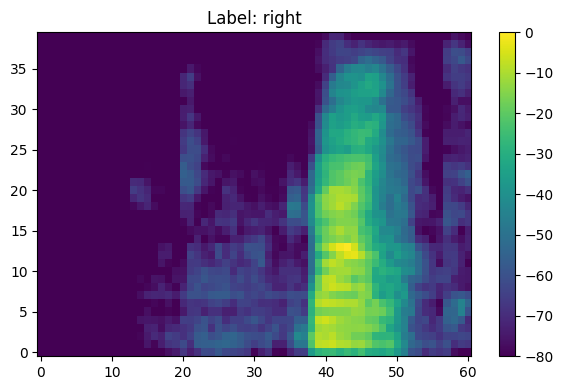

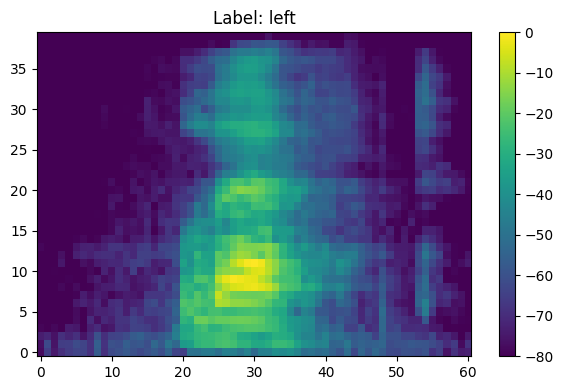

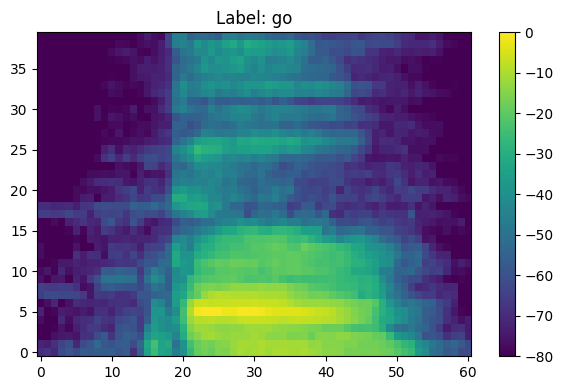

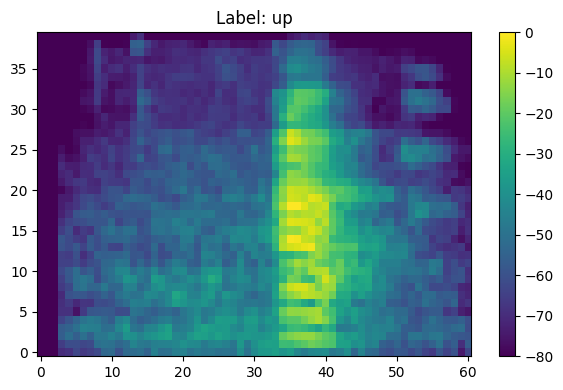

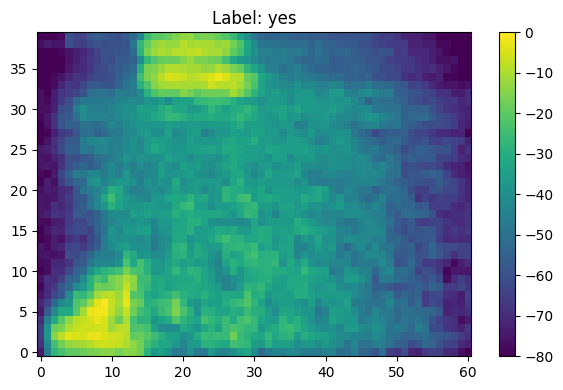

In [ ]:
import random

for _ in range(5):
    idx = random.randint(0, len(log_mel_spectrograms) - 1)
    plot_mel_spectrogram(log_mel_spectrograms[idx], labels[idx])



In [ ]:
np.save(os.path.join(save_path, 'X_log_mel_spectrograms_base_UK3000.npy'), np.array(log_mel_spectrograms))
np.save(os.path.join(save_path, 'y_log_mel_spectrograms_base_UK3000.npy'), np.array(labels))
print("Feature extraction done and saved.")


Feature extraction done and saved.


In [ ]:
X = np.load(os.path.join(save_path, 'X_log_mel_spectrograms_base_UK3000.npy'))
y = np.load(os.path.join(save_path, 'y_log_mel_spectrograms_base_UK3000.npy'))

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)


X shape: (30000, 61, 40)
y shape: (30000,)


In [ ]:
from collections import Counter
label_map = { 'off': 0, 'left': 1, 'down': 2, 'up': 3, 'go': 4, 'on': 5,
              'stop': 6, 'unknown': 7, 'right': 8, 'yes': 9 }

inv_label_map = {v: k for k, v in label_map.items()}
label_counts = Counter(y)
for label_idx in sorted(label_counts):
    label_name = inv_label_map.get(label_idx, 'unknown')
    print(f"{label_name}: {label_counts[label_idx]} samples")

off: 3000 samples
left: 3000 samples
down: 3000 samples
up: 3000 samples
go: 3000 samples
on: 3000 samples
stop: 3000 samples
unknown: 3000 samples
right: 3000 samples
yes: 3000 samples


In [ ]:
# Normalize
X = np.array([x / np.max(np.abs(x)) if np.max(np.abs(x)) > 0 else x for x in X])

# ✅ Remove extra dims and reshape correctly
X = np.squeeze(X)  # removes all dimensions of size 1, if any
if X.ndim == 3:
    X = X[..., np.newaxis]  # adds only (61, 40, 1) as required
CLASSES = len(keyword_list)
y_cat = to_categorical(y, CLASSES)

In [ ]:
print("X shape:", X.shape)  # (num_samples, time_steps, n_mels)
print("y shape:", y.shape)  # (num_samples,)

X shape: (30000, 61, 40, 1)
y shape: (30000,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y)

In [ ]:
def build_model(hparams):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    filters = hparams['filters']
    kernel_size = hparams['kernel_size']
    use_bn = hparams['use_bn']
    num_res_blocks = hparams['residual_blocks']
    num_fc_layers = hparams['fc_layers']
    use_dropout = hparams['use_dropout']

    inputs = layers.Input(shape=input_shape, name="input_layer")

    # Initial Conv Block
    x = layers.Conv2D(filters, kernel_size, padding='same')(inputs)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="relu1_1")(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = layers.ReLU(name="relu1_2")(x)
    x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    # Residual Blocks
    for block_idx in range(num_res_blocks):
        # Skip projection with BN
        skip = layers.Conv2D(filters * 2, (1,1), strides=(2,2), padding='same')(x)
        skip = layers.BatchNormalization()(skip)

        # Residual path
        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(x)
        if use_bn:
            y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)

        y = layers.Conv2D(filters * 2, kernel_size, padding='same')(y)
        if use_bn:
            y = layers.BatchNormalization()(y)

        y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(y)

        # Add and ReLU
        x = layers.add([y, skip])
        x = layers.ReLU(name=f"res_relu_{block_idx}")(x)

        filters *= 2  # Double filters

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name="gap")(x)

    # Dense layers
    fc_config = {
        1: [64],
        2: [128, 64],
        3: [256, 128, 64],
        4: [512, 256, 128, 64]
    }

    for i, units in enumerate(fc_config[num_fc_layers]):
        x = layers.Dense(units, activation='relu', name=f"fc{i+1}")(x)
        if use_dropout:
            x = layers.Dropout(0.3, name=f"dropout{i+1}")(x)

    outputs = layers.Dense(CLASSES, activation='softmax', name="output_layer")(x)
    return Model(inputs, outputs, name="FixedCNN")


In [ ]:
hparams = {
    'filters': 32,
    'kernel_size': 5,
    'use_bn': False,
    'residual_blocks': 1,
    'fc_layers': 4,
    'use_dropout': True
}

In [ ]:
model = build_model(hparams)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "FixedCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 61, 40, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 61, 40,    │        832 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_1 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 40,    │     25,632 │ relu1_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu1_2 (ReLU)      │ (None, 61, 40,    │          0 │ conv2d_1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 31, 20,    │          0 │ relu1_2[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 31, 20,    │     51,264 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 31, 20,    │          0 │ conv2d_3[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 31, 20,    │    102,464 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 10,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 10,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 10,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 10,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_relu_0 (ReLU)   │ (None, 16, 10,    │          0 │ add[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 64)        │          0 │ res_relu_0[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc1 (Dense)         │ (None, 512)       │     33,280 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout1 (Dropout)  │ (None, 512)       │          0 │ fc1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 388,970 (1.48 MB)

 Trainable params: 388,842 (1.48 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[early_stop])

Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.1344 - loss: 2.2380 - val_accuracy: 0.3012 - val_loss: 1.7770
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3546 - loss: 1.6172 - val_accuracy: 0.6215 - val_loss: 0.8986
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.6767 - loss: 0.8691 - val_accuracy: 0.8237 - val_loss: 0.5301
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8267 - loss: 0.5527 - val_accuracy: 0.8803 - val_loss: 0.3741
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8638 - loss: 0.4435 - val_accuracy: 0.8810 - val_loss: 0.3567
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.8853 - loss: 0.3735 - val_accuracy: 0.8895 - val_loss: 0.3446
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.8981 - loss: 0.3377 - val_accuracy: 0.9120 - val_loss: 0.2845
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9070 - loss: 0.2977 - v

In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {acc * 100:.2f}%")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9370 - loss: 0.2109

Test Accuracy: 93.82%


In [ ]:
y_pred = model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [ ]:
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_true_classes, y_pred_classes, target_names=keyword_list))

              precision    recall  f1-score   support

         off       0.85      0.96      0.90       600
        left       0.98      0.93      0.95       600
        down       0.98      0.92      0.95       600
          up       0.94      0.92      0.93       600
          go       0.93      0.93      0.93       600
          on       0.95      0.94      0.95       600
        stop       0.96      0.96      0.96       600
     unknown       0.86      0.90      0.88       600
       right       0.97      0.96      0.97       600
         yes       0.97      0.96      0.97       600

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



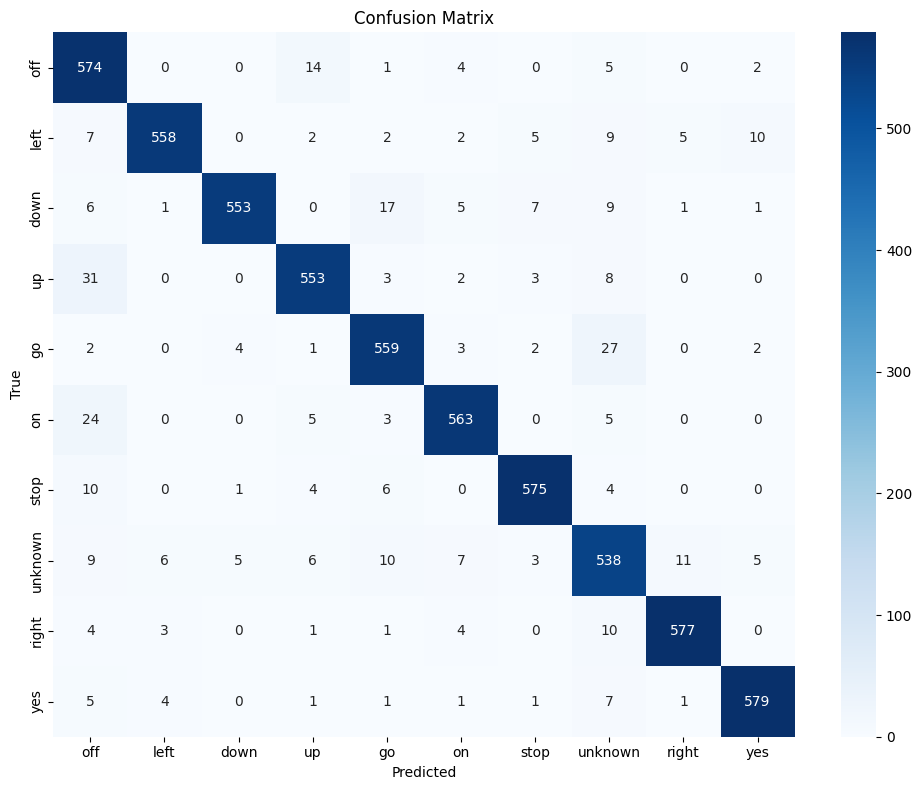

In [ ]:
import seaborn as sns

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=keyword_list, yticklabels=keyword_list)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



In [ ]:

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (24000, 61, 40, 1)
y_train: (24000, 10)
X_test: (6000, 61, 40, 1)
y_test: (6000, 10)


In [ ]:
model.save(os.path.join(save_path, 'CNN_BASE_UK3000.h5'))

In [ ]:
def extract_features_from_file(file_path):
    try:
        signal, _ = librosa.load(file_path, sr=16000)
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None

    if len(signal) >= SAMPLES_TO_CONSIDER:
        signal = signal[:SAMPLES_TO_CONSIDER]
    else:
        signal = np.pad(signal, (SAMPLES_TO_CONSIDER - len(signal), 0), mode='constant')

    signal = signal.astype(np.float32)
    windowed = signal * hamming_window(SAMPLES_TO_CONSIDER)

    mel_spec = librosa.feature.melspectrogram(
        y=windowed,
        sr=16000,
        n_mels=40,
        n_fft=frame_length,
        win_length=frame_length,
        hop_length=hop_length,
        center=False
    )

    log_mel = librosa.power_to_db(mel_spec, ref=np.max)
    feature = log_mel.T

    # Normalize like training
    feature = feature / np.max(np.abs(feature))

    # Add channel dim
    if feature.ndim == 2:
        feature = feature[..., np.newaxis]

    return np.expand_dims(feature, axis=0)  # shape (1, 61, 40, 1)


In [ ]:
test_file_path = "/content/drive/MyDrive/NITDGP/Base Model Variations/UnknownIs3000/sdfds_hello_1 (1).wav"

X_new = extract_features_from_file(test_file_path)

<ipython-input-67-4205133968>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  signal, _ = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [ ]:
prediction = model.predict(X_new)
predicted_index = np.argmax(prediction)
print(f"Predicted keyword: {keyword_list[predicted_index]}")
print(f"Confidence: {prediction[0][predicted_index]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted keyword: up
Confidence: 0.9754
